<a href="https://colab.research.google.com/github/MichalBalcerak/ML24-25/blob/main/Homework10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [90]:
import torch
import torchvision
from matplotlib import pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

# Training function

In [95]:
def train_model(net, lr=0.001, epochs=16):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Working on {device}")

  net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr)
  net.train()

  for epoch in range(epochs):
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)

        loss = F.cross_entropy(batch_outputs, batch_labels, reduction="mean")
        #print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()
        optimizer.step()

  good = 0
  wrong = 0

  net.eval()
  with torch.no_grad():
      for batch, data in enumerate(testloader):
          datapoint, label = data

          datapoint = datapoint.to(device)
          label = label.to(device)

          prediction = net(datapoint)
          classification = torch.argmax(prediction)


          if classification.item() == label.item():
              good += 1
          else:
              wrong += 1

  print("accuracy = ", good/(good+wrong))
  return net

# LeNet5

In [96]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels= 1, out_channels= 6, kernel_size = 5)
        self.conv2 = torch.nn.Conv2d(in_channels= 6, out_channels= 16, kernel_size = 5)
        self.conv3 = torch.nn.Conv2d(in_channels= 16, out_channels= 120, kernel_size = 4)

        self.relu = torch.nn.ReLU()

        self.avgpool = torch.nn.AvgPool2d(kernel_size= 2, stride = 2)

        self.linear1 = torch.nn.Linear(120, 80)
        self.linear2 = torch.nn.Linear(80,10)

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):

        x = self.relu(self.conv1(x))     # B, 6, 24, 24
        x = self.avgpool(x)               # B, 6, 12, 12
        x = self.relu(self.conv2(x))      # B, 16, 8, 8
        x = self.avgpool(x)               # B, 16, 4, 4
        x = self.relu(self.conv3(x))      # B, 120, 1, 1

        x = x.squeeze(-1).squeeze(-1)     # B, 120

        x = self.relu(self.linear1(x))    # B, 80
        x = self.linear2(x)               # B, 10

        x = self.dropout(x)
        return x

# MLP

In [97]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(1*28*28, 1024)

        self.linear2 = torch.nn.Linear(1024, 2048)
        self.linear3 = torch.nn.Linear(2048, 256)
        self.linear4 = torch.nn.Linear(256, 10)


        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):      # B, 1, 28, 28
        x = self.flatten(x)    # B, 784

        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)

        x = self.linear3(x)
        x = self.relu(x)

        x = self.linear4(x)

        x = self.dropout(x)
        return x

# Training MLP model

In [98]:
mlp = train_model(net=MLP(), epochs=8)

leNet5 = train_model(net=LeNet5(), epochs=16)

Working on cuda
accuracy =  0.9839
Working on cuda
accuracy =  0.9805


# generate 10 random Gaussian noise images with corresponding labels

In [111]:
def generate_initial_images(seed=42):
    torch.manual_seed(seed)
    input_images = []
    for _ in range(10):
        image = torch.nn.Parameter(torch.randn((1, 1, 28, 28), device=device))
        input_images.append(image)
    return input_images

labels = []
for i in range(10):
    labels.append(i)

# Image optimization function (default $L_2$ penalty = 0)

In [135]:
def optimize_images(net, input_images, labels, steps=800, lr=0.001, lambda_l2=0):
  optimizer = torch.optim.Adam(input_images, lr=lr)
  confidence_history = [[] for _ in range(10)]
  #image_snapshots = [[] for _ in range(10)]
  net.eval()
  for step in range(steps):
    for i in range(10):
        optimizer.zero_grad()
        image = input_images[i]
        target_label = torch.tensor([labels[i]], device=device)

        output = net(image)

        l2_penalty = image.pow(2).mean()

        loss = F.cross_entropy(output, target_label) + lambda_l2 * l2_penalty
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            image.clamp_(0, 1)

        if step % 10 == 0:
            probs = torch.softmax(output, dim=1)
            confidence = probs[0, labels[i]].item()
            confidence_history[i].append(confidence)
        '''
        if step % 50 == 0:
            snapshot = image.detach().cpu().clone().squeeze()
            image_snapshots[i].append(snapshot)
        '''

  steps_list = [i * 10 for i in range(len(confidence_history[0]))]

  plt.figure(figsize=(10, 5))
  for i in range(10):
      plt.plot(steps_list, confidence_history[i], label=f"Digit {i}")
  plt.xlabel("Optimization step")
  plt.ylabel("Confidence")
  plt.title(f"Confidence evolution during optimization - \nλ={lambda_l2:.2f}")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()


  fig, axs = plt.subplots(1, 10, figsize=(15, 2))
  for i in range(10):
      image_tensor = input_images[i].detach().cpu().squeeze()
      axs[i].imshow(image_tensor, cmap='gray')
      axs[i].axis('off')
      axs[i].set_title(f"{i}\nλ={lambda_l2:.2f}")


# Optimize images with MLP

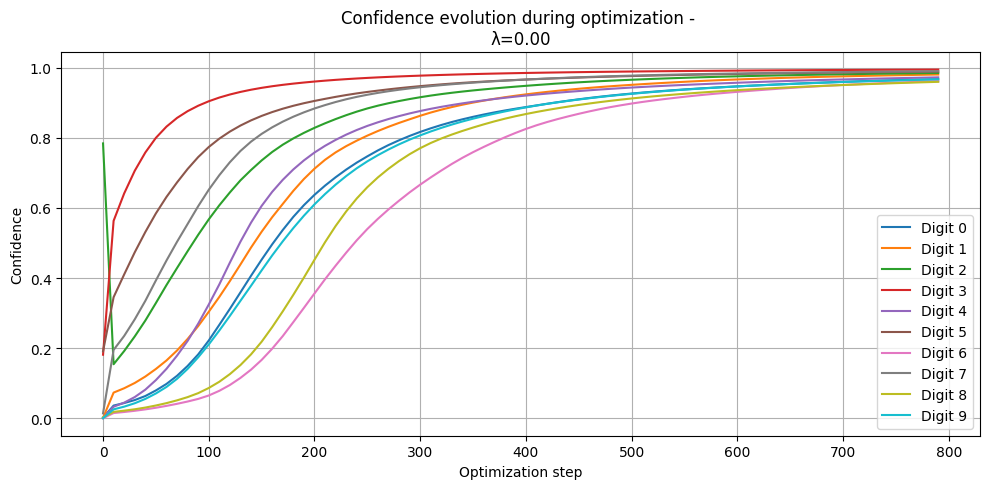

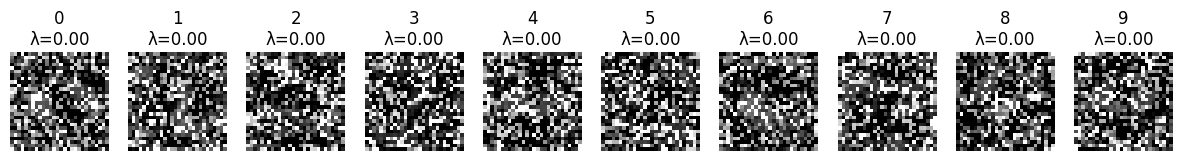

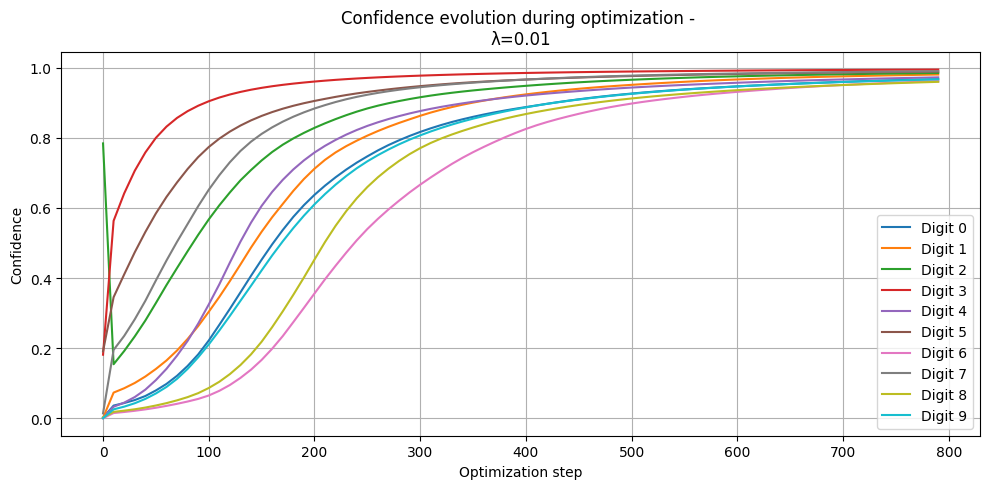

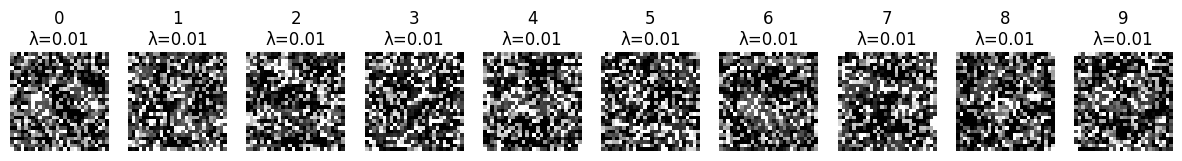

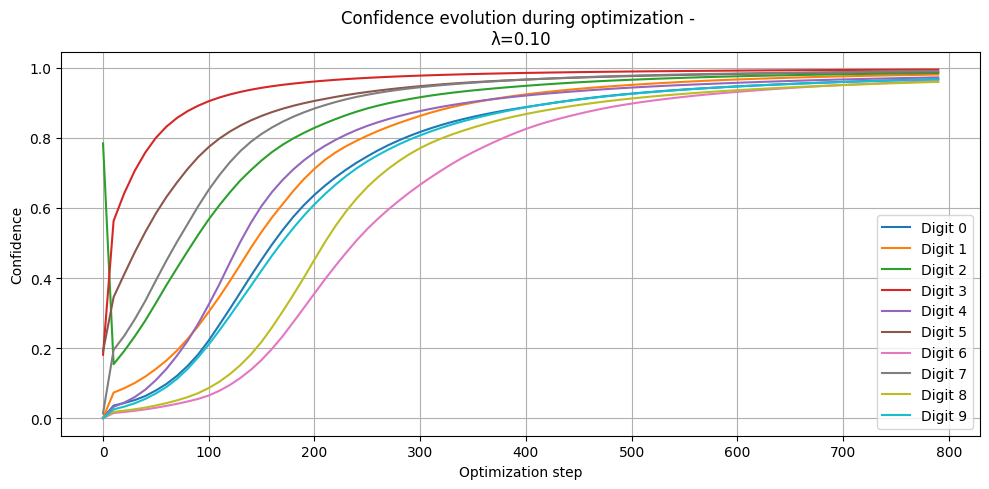

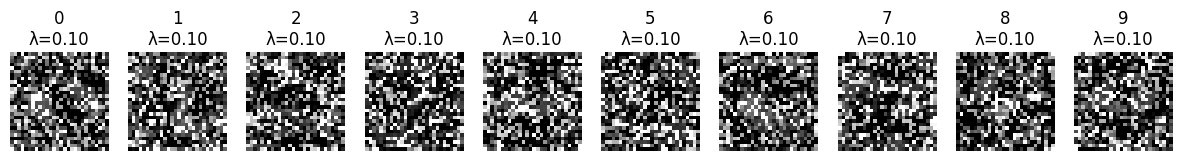

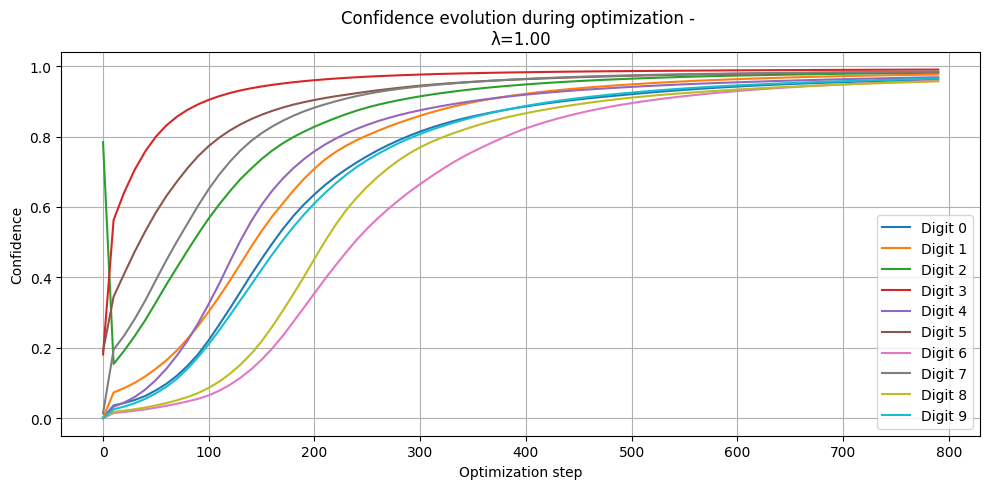

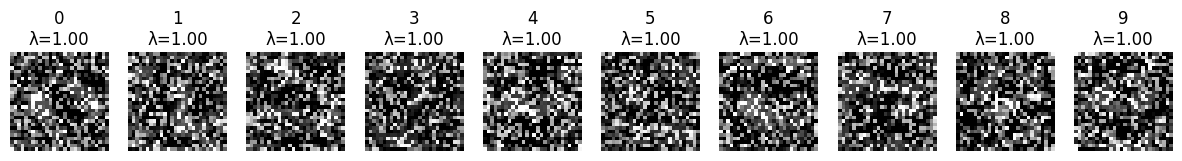

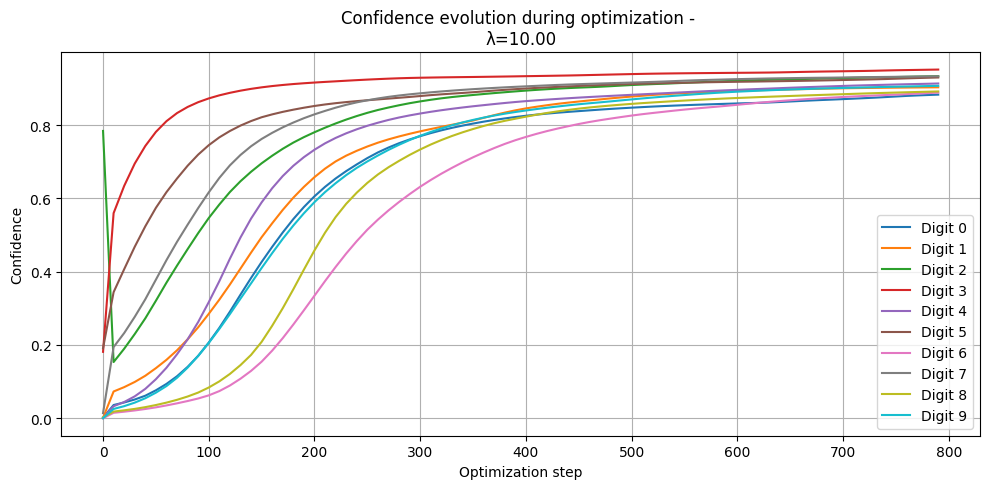

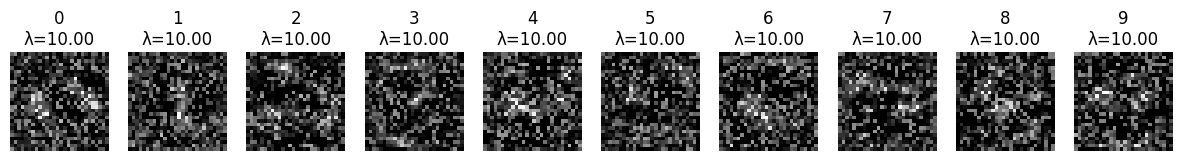

In [136]:
optimize_images(net=mlp, input_images=generate_initial_images(seed=42), labels=labels, lambda_l2=0.0)
for i in range(-2, 2):
    lambda_val = 10 ** i
    input_images = generate_initial_images(seed=42)
    optimize_images(net=mlp, input_images=input_images, labels=labels, lambda_l2=lambda_val)
    plt.show()

# Optimize images with LeNet5

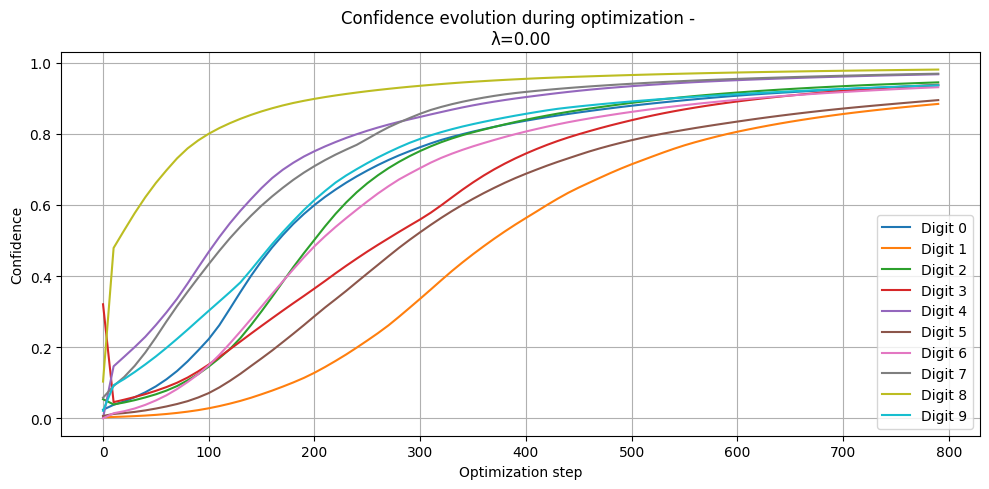

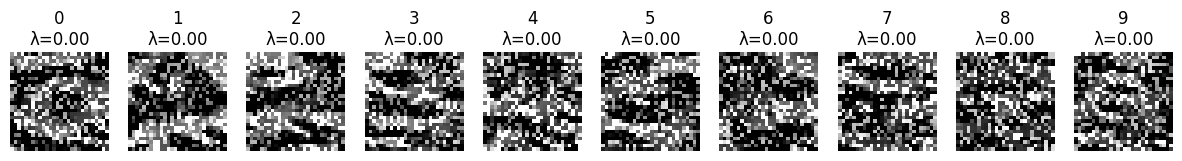

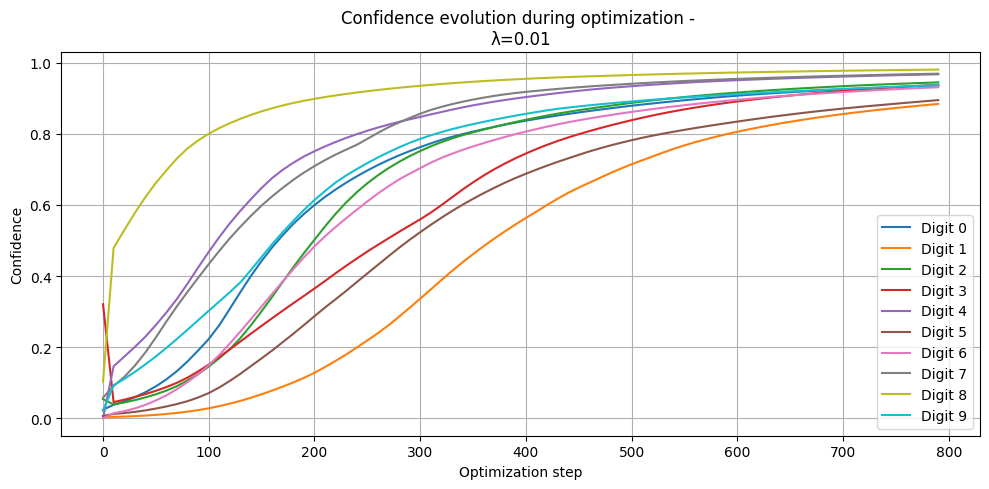

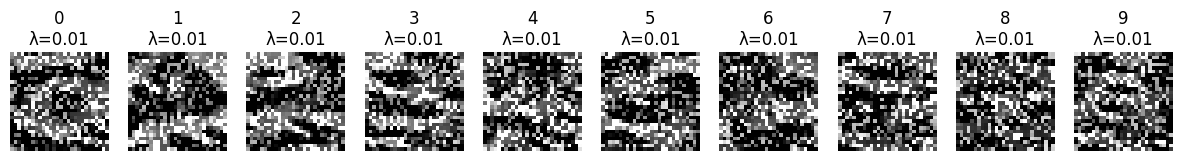

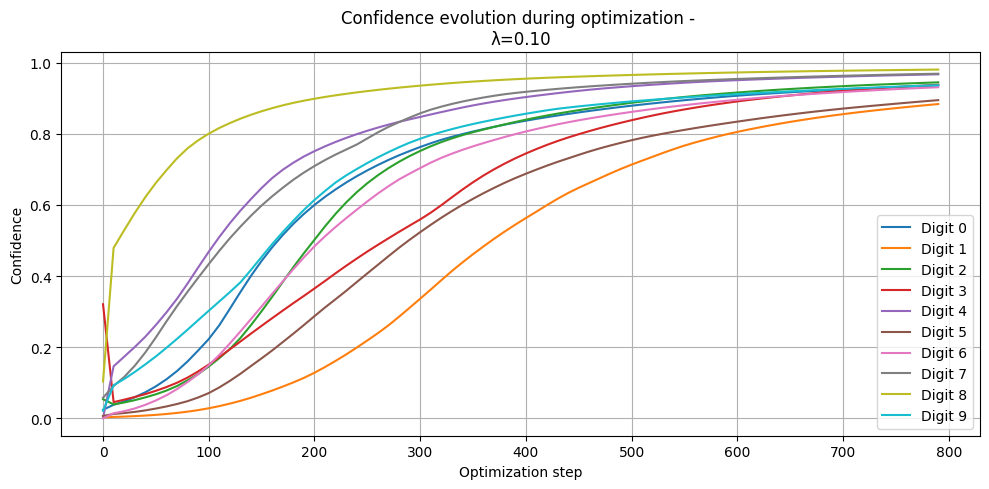

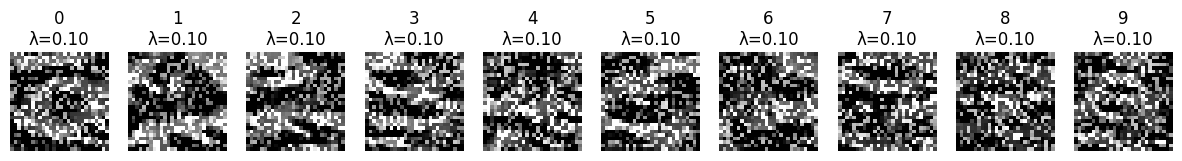

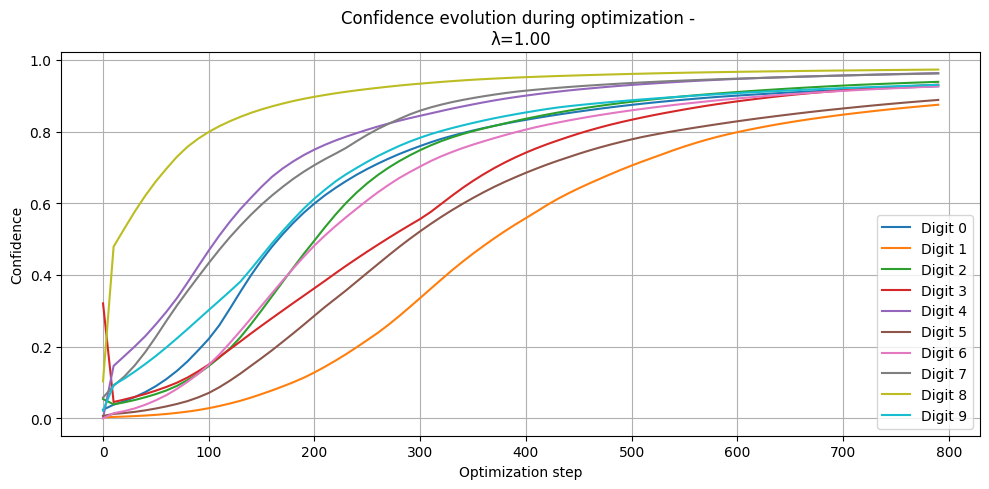

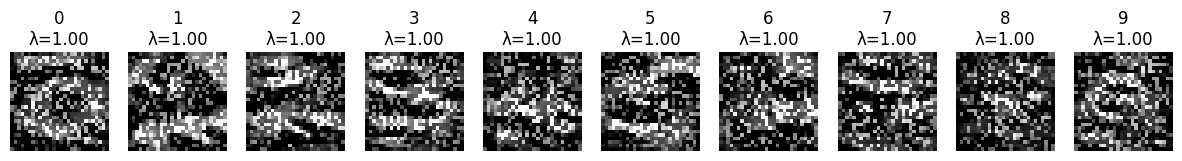

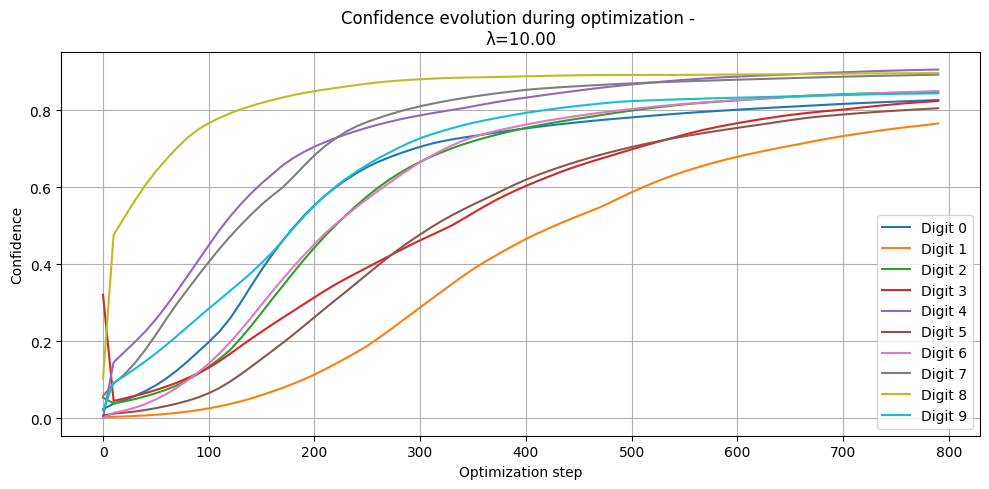

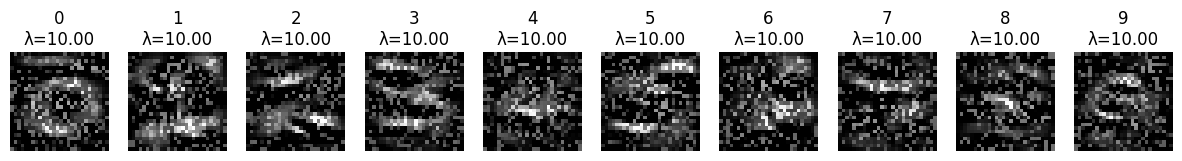

In [137]:
optimize_images(net=leNet5, input_images=generate_initial_images(seed=42), labels=labels, lambda_l2=0.0)
for i in range(-2, 2):
    lambda_val = 10 ** i
    input_images = generate_initial_images(seed=42)
    optimize_images(net=leNet5, input_images=input_images, labels=labels, lambda_l2=lambda_val)
    plt.show()

# Comparing images generated by the CNN (LeNet5) and by the MLP

The digits generated using the CNN are more readable and more closely resemble real MNIST digits than those produced by the MLP.

This is because CNNs have architectural advantages like local connectivity and weight sharing, which help them detect meaningful spatial patterns like edges, corners, and shapes — similar to how humans recognize digits. These inductive biases allow CNNs to generate images with clearer, more digit-like structures.

In contrast, MLPs treat all input pixels equally and do not exploit spatial relationships, which leads to noisier and less realistic results.

*I completed only Task 1.*